In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
import re
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_excel('emails.xlsx')  
print(df.head())

# Eksik veri var mı 
print(df.isnull().sum())

# Etiketler
print(df['spam'].value_counts())


                                                text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1
text    0
spam    0
dtype: int64
spam
0    4360
1    1368
Name: count, dtype: int64


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # noktalama kaldır
    text = re.sub(r"\s+", " ", text)  # fazla boşlukları temizle
    return text.strip()


df['text_clean'] = df['text'].apply(clean_text) # verileri temizle
df['tokens'] = df['text_clean'].apply(lambda x: x.split()) # Tokenizasyon: kelimeleri boşlukla ayır
# Örnek 
print(df[['text', 'text_clean', 'tokens']].head())


                                                text  \
0  Subject: naturally irresistible your corporate...   
1  Subject: the stock trading gunslinger  fanny i...   
2  Subject: unbelievable new homes made easy  im ...   
3  Subject: 4 color printing special  request add...   
4  Subject: do not have money , get software cds ...   

                                          text_clean  \
0  subject naturally irresistible your corporate ...   
1  subject the stock trading gunslinger fanny is ...   
2  subject unbelievable new homes made easy im wa...   
3  subject color printing special request additio...   
4  subject do not have money get software cds fro...   

                                              tokens  
0  [subject, naturally, irresistible, your, corpo...  
1  [subject, the, stock, trading, gunslinger, fan...  
2  [subject, unbelievable, new, homes, made, easy...  
3  [subject, color, printing, special, request, a...  
4  [subject, do, not, have, money, get, software,..

In [21]:
# Tüm kelimeleri bir listede toplayıp ardından sıklıklarına göre sıralayacağız
all_words = [word for tokens in df['tokens'] for word in tokens]

# Kelimeleri sıklıklarına göre sıralamak için Counter kullanılabilir
from collections import Counter
word_counts = Counter(all_words)

# En sık geçen kelimelere indeks ata
vocab = {word: idx+2 for idx, (word, _) in enumerate(word_counts.most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

# Tokenleri indekslere çevir
def encode_tokens(tokens, vocab):
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

df['encoded'] = df['tokens'].apply(lambda x: encode_tokens(x, vocab))
mean_token_length = df['encoded'].apply(len).mean()
# Örnek çıktı
print(df[['tokens', 'encoded']].head())
print(f"Ortalama token uzunluğu: {mean_token_length:.2f}")


                                              tokens  \
0  [subject, naturally, irresistible, your, corpo...   
1  [subject, the, stock, trading, gunslinger, fan...   
2  [subject, unbelievable, new, homes, made, easy...   
3  [subject, color, printing, special, request, a...   
4  [subject, do, not, have, money, get, software,...   

                                             encoded  
0  [15, 5503, 11422, 17, 468, 1676, 3694, 13, 410...  
1  [15, 2, 455, 171, 20353, 20354, 13, 4662, 70, ...  
2  [15, 8631, 62, 4663, 270, 779, 3868, 4962, 3, ...  
3  [15, 1961, 4070, 485, 182, 357, 61, 123, 230, ...  
4  [15, 55, 39, 24, 216, 73, 229, 2587, 26, 87, 2...  
Ortalama token uzunluğu: 227.32


In [10]:
# Tensor'ları pad et
MAX_LEN = 150  # max sequence length
def pad_sequence_fn(seq, max_len=MAX_LEN):
    seq = seq[:max_len]
    return seq + [vocab["<PAD>"]] * (max_len - len(seq))

df['padded'] = df['encoded'].apply(pad_sequence_fn)

# Giriş ve çıkış tensor'ları
X = torch.tensor(df['padded'].tolist(), dtype=torch.long)
y = torch.tensor(df['spam'].tolist(), dtype=torch.float32)


In [ ]:
class SpamDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Datasetler
train_dataset = SpamDataset(X_train, y_train)
test_dataset = SpamDataset(X_test, y_test)

BATCH_SIZE = 4  # Batch size olarak 4 seçildi

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
class LSTMEmail(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers):
        super(LSTMEmail, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        last_hidden = hidden[-1]
        out = self.fc(last_hidden)
        return self.sigmoid(out).squeeze()


In [14]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")


In [15]:
# Cihaz seçimi (GPU varsa kullan)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parametreleri
vocab_size = len(vocab)
embed_dim = 64
hidden_dim = 32
num_layers = 2

# Modeli oluştur ve cihaza taşı
model = LSTMEmail(vocab_size, embed_dim, hidden_dim, num_layers).to(device)

# Kayıp fonksiyonu ve optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Eğitimi başlat
train_model(model, train_loader, criterion, optimizer, device, num_epochs=20)


Epoch 1/20, Loss: 582.7823, Accuracy: 0.7763
Epoch 2/20, Loss: 400.7287, Accuracy: 0.8649
Epoch 3/20, Loss: 218.5254, Accuracy: 0.9105
Epoch 4/20, Loss: 122.2603, Accuracy: 0.9618
Epoch 5/20, Loss: 76.2570, Accuracy: 0.9799
Epoch 6/20, Loss: 55.9092, Accuracy: 0.9838
Epoch 7/20, Loss: 33.9545, Accuracy: 0.9932
Epoch 8/20, Loss: 40.3525, Accuracy: 0.9904
Epoch 9/20, Loss: 17.3472, Accuracy: 0.9969
Epoch 10/20, Loss: 11.9256, Accuracy: 0.9980
Epoch 11/20, Loss: 9.6391, Accuracy: 0.9985
Epoch 12/20, Loss: 16.6782, Accuracy: 0.9972
Epoch 13/20, Loss: 22.1111, Accuracy: 0.9963
Epoch 14/20, Loss: 18.6637, Accuracy: 0.9969
Epoch 15/20, Loss: 24.7456, Accuracy: 0.9939
Epoch 16/20, Loss: 13.5399, Accuracy: 0.9969
Epoch 17/20, Loss: 8.8980, Accuracy: 0.9987
Epoch 18/20, Loss: 4.7021, Accuracy: 0.9993
Epoch 19/20, Loss: 2.1113, Accuracy: 0.9998
Epoch 20/20, Loss: 4.2083, Accuracy: 0.9991


In [22]:
# Eğitilmiş modeli kaydet
torch.save(model.state_dict(), 'lstm_spam_model_0.pt')
print("Model başarıyla kaydedildi.")


Model başarıyla kaydedildi.


In [23]:
model = LSTMEmail(vocab_size, embed_dim, hidden_dim, num_layers)
model.load_state_dict(torch.load('lstm_spam_model_0.pt'))
model.to(device)   # GPU veya CPU’ya taşı
model.eval()       # Değerlendirme moduna al


LSTMEmail(
  (embedding): Embedding(33720, 64, padding_idx=0)
  (lstm): LSTM(64, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [24]:
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [25]:
# Accuracy ve F1 score
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9773
F1 Score: 0.9542


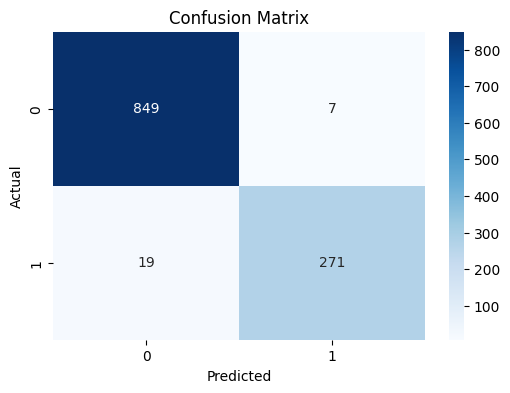

In [19]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
